### **Estudo sobre o Teorema da Melhor Aproximação de uma matriz**

---

Gabriel Oukawa <br>
Álgebra linear para ciência de dados <br>
2º Semestre de 2025

---


O presente relatório tem como objetivo analisar este teorema usando o método de decomposição em valores singulares (*singular value decomposition*, SVD). <br>
Para isso, os resultados apresentarão as imagens reconstruídas para diferentes valores de posto (*r*), analisando o erro de reconstrução correspondente a cada valor.

## **1. Análise para uma única imagem, variando o posto da matriz (*r*)**

In [29]:
# Bibliotecas necessárias
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

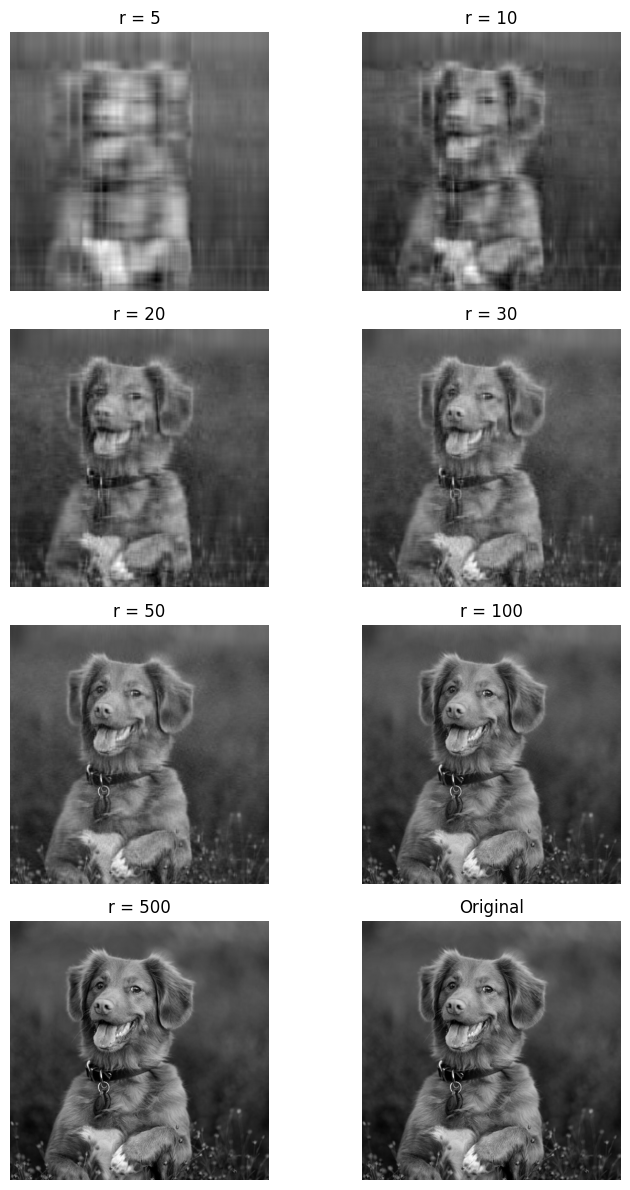

In [30]:
# Ler imagem e aplicar SVD para diferentes valores de "r" (imagem única)
A = imageio.imread('https://storage.googleapis.com/kaggle-datasets-images/2742826/4739736/2850b9592e450d523815d509b9500140/dataset-card.jpg')

A = cv2.resize(A, (1000, 1000))

X = np.mean(A, -1);

U, S, VT = np.linalg.svd(X, full_matrices=False)
S_diag = np.diag(S)

ranks = (5, 10, 20, 30, 50, 100, 500, 1000)
errors = []

plt.figure(figsize=(8, 12))

for i, r in enumerate(ranks):
    # Se valor de "r" for igual a 1000, mostrar imagem original
    if r == 1000:

        plt.subplot(4, 2, i + 1)
        plt.imshow(X, cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Se o o valor de "r" for diferente de 1000, aplicar SVD
    else:
        Xapprox = U[:,:r] @ S_diag[0:r,:r] @ VT[:r,:]

        plt.subplot(4, 2, i + 1)
        plt.imshow(Xapprox, cmap='gray')
        plt.title(f'r = {r}')
        plt.axis('off')

plt.tight_layout()
plt.show()

A figura acima mostra o resultado de reconstrução ao variar o posto da matriz.
Ao reconstruir a imagem, observa-se que, para valores de *r* < 50, os erros de reconstrução são evidentes, resultando em baixa qualidade. Para *r* igual ou superior a 100, os artefatos de reconstrução tornam-se praticamente imperceptíveis. <br>
Com valores altos de *r* (> 250), a imagem reconstruída praticamente não difere da original.

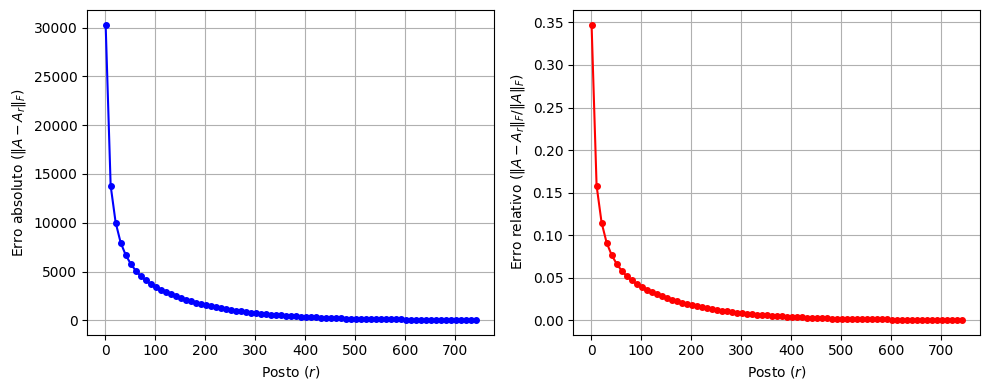

In [31]:
# Norma Frobenius
ranks = range(1, 751, 10)

error_abs = []
error_rel = []

for r in ranks:
    Xapprox = U[:, :r] @ S_diag[0:r, :r] @ VT[:r, :]

    abs = np.linalg.norm(X - Xapprox, 'fro')
    error_abs.append(abs)

    rel = abs / np.linalg.norm(X, 'fro')
    error_rel.append(rel)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Erro absoluto
axes[0].plot(ranks, error_abs, color='blue', marker='o', markersize=4, linestyle='-')
axes[0].set_xlabel('Posto ($r$)')
axes[0].set_ylabel(r'Erro absoluto ($\|A - A_r\|_F$)')
axes[0].grid(True)

# Erro relativo
axes[1].plot(ranks, error_rel, color='red', marker='o', markersize=4, linestyle='-')
axes[1].set_xlabel(r'Posto ($r$)')
axes[1].set_ylabel(r'Erro relativo ($\|A - A_r\|_F / \|A\|_F$)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

A figura acima mostra o erro acumulado de reconstrução utilizando a norma *Frobenius*, tanto em termos absolutos (linha azul), como relativos (linha vermelha). <br>
Para valores de *r* > 100, a reconstrução perde apenas cerca de 4% da energia da matriz original. Ao aumentar *r* para 300 ou mais, essa perda cai para aproximadamente 1%, a partir de onde os ganhos adicionais tornam-se marginais.


## **2. Análise para múltiplas imagens (mosaico), variando o posto da matriz (*r*) e com perturbações**

In [32]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from PIL import Image, ImageOps, ImageEnhance, ImageFilter

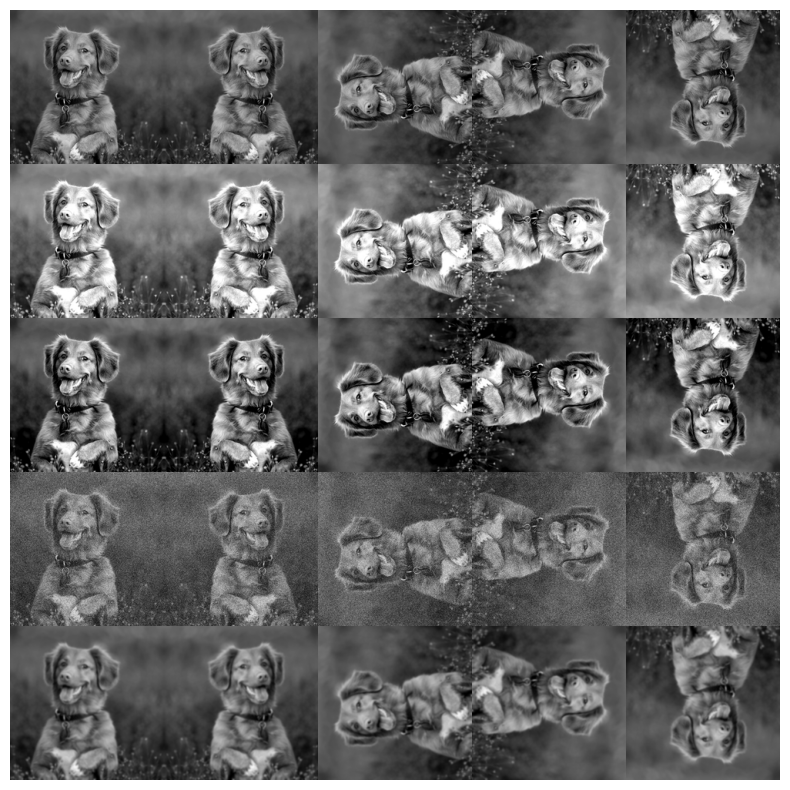

In [33]:
# Ler a imagem e construir um mosaico com 25 variações
B = Image.fromarray(imageio.imread("https://storage.googleapis.com/kaggle-datasets-images/2742826/4739736/2850b9592e450d523815d509b9500140/dataset-card.jpg")).convert("L")

transforms = [lambda x: x, lambda x: ImageEnhance.Brightness(x).enhance(1.5), # Perturbação 1: aumento do brilho
              lambda x: ImageEnhance.Contrast(x).enhance(1.5), # Perturbação 2: aumento do contraste
              lambda x: Image.fromarray(np.clip(np.array(x, dtype=np.float32) + np.random.normal(0, 100, np.array(x).shape), 0, 255).astype(np.uint8)), # Perturbação 3: ruído
              lambda x: x.filter(ImageFilter.GaussianBlur(5))] # Perturbação 4: borrão

rotations = [lambda x: x, ImageOps.mirror, # Perturbação 5: inverter
             lambda x: x.rotate(90, expand=True), # Perturbação 6: rotação 90 graus horário
             lambda x: x.rotate(-90, expand=True), # Perturbação 7: rotação 90 graus anti-horário
             lambda x: x.rotate(180, expand=True)] # Perturbação 8: rotação 180 graus

# As dimensões da nova imagem (mosaico) são iguais à imagem original
C = Image.new("L", (1000, 1000))

[C.paste(rot(trans(B)).resize((200, 200),
                                     Image.Resampling.LANCZOS),
                                      ((i*5+j)*200%1000, (i*5+j)//5*200))
                                        for i, trans in enumerate(transforms)
                                        for j, rot in enumerate(rotations)]

plt.figure(figsize=(10, 10))
plt.imshow(C, cmap="gray")
plt.axis("off")
plt.show()

A figura acima apresenta um mosaico com 25 variações da mesma imagem. A primeira linha mostra as imagens originais, seguida por versões com brilho aumentado, contraste ampliado, adição de ruído e aplicação de borrão, respectivamente.

In [34]:
# Aplicar SVD para diferentes valores de "r" (mosaico de 25 imagens)
X = np.array(C)

U, S, VT = np.linalg.svd(X, full_matrices=False)
S_diag = np.diag(S)

ranks = (5, 10, 20, 30, 50, 100, 500, 1000)
errors = []

plt.figure(figsize=(14, 20))

for i, r in enumerate(ranks):
    # Se valor de "r" for igual a 1000, mostrar imagem original
    if r == 1000:

        plt.subplot(4, 2, i + 1)
        plt.imshow(X, cmap='gray')
        plt.title('Original')
        plt.axis('off')

    # Se o o valor de "r" for diferente de 1000, aplicar SVD
    else:
        Xapprox = U[:,:r] @ S_diag[0:r,:r] @ VT[:r,:]

        plt.subplot(4, 2, i + 1)
        plt.imshow(Xapprox, cmap='gray')
        plt.title(f'r = {r}')
        plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

A figura acima mostra o resultado de reconstrução para diferentes postos, organizada em um mosaico com 25 variações. A primeira linha mostra as imagens originais, seguida por versões com brilho aumentado, contraste ampliado, adição de ruído e aplicação de borrão, respectivamente. <br>
Mesmo no formato de mosaico, observa-se que para *r* < 50 os erros de reconstrução são bastante evidentes. Com *r* = 100 ainda se notam artefatos, sobretudo nas variações com brilho e contraste aumentados. Já para valores elevados de *r* (> 500), a imagem reconstruída torna-se praticamente indistinguível da original.

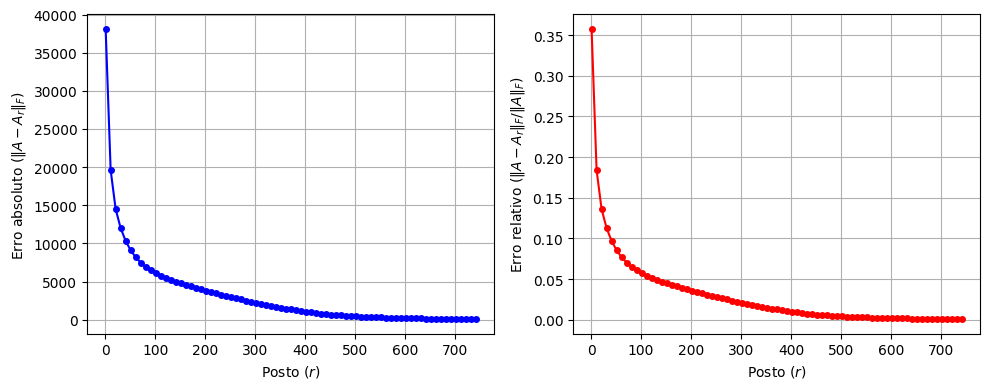

In [35]:
# Norma Frobenius
ranks = range(1, 751, 10)

errors_abs = []
errors_rel = []

for r in ranks:
    Xapprox = U[:, :r] @ S_diag[0:r, :r] @ VT[:r, :]

    abs = np.linalg.norm(X - Xapprox, 'fro')
    errors_abs.append(abs)

    rel = abs / np.linalg.norm(X, 'fro')
    errors_rel.append(rel)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Erro absoluto
axes[0].plot(ranks, errors_abs, color='blue', marker='o', markersize=4, linestyle='-')
axes[0].set_xlabel('Posto ($r$)')
axes[0].set_ylabel(r'Erro absoluto ($\|A - A_r\|_F$)')
axes[0].grid(True)

# Erro relativo
axes[1].plot(ranks, errors_rel, color='red', marker='o', markersize=4, linestyle='-')
axes[1].set_xlabel(r'Posto ($r$)')
axes[1].set_ylabel(r'Erro relativo ($\|A - A_r\|_F / \|A\|_F$)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

A figura acima mostra o erro acumulado de reconstrução para o mosaico de 25 imagens, tanto em termos absolutos (linha azul), como relativos (linha vermelha). <br>
Diferente da imagem única, um *r* = 100 resulta em uma perda de aproximadamente 6% em comparação com a matriz original. Para valores de *r* entre 100 e 400, a melhora na reconstrução segue uma tendência relativamente linear. Já para *r* > 450, a perda cai para 1%, onde os ganhos adicionais tornam-se marginais acima disso.


## **3. Análise para múltiplas imagens, variando o posto da matriz (*r*) e com perturbações**

In [36]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image, ImageEnhance

/tmp/ipython-input-1383363270.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = Image.fromarray(imageio.imread(


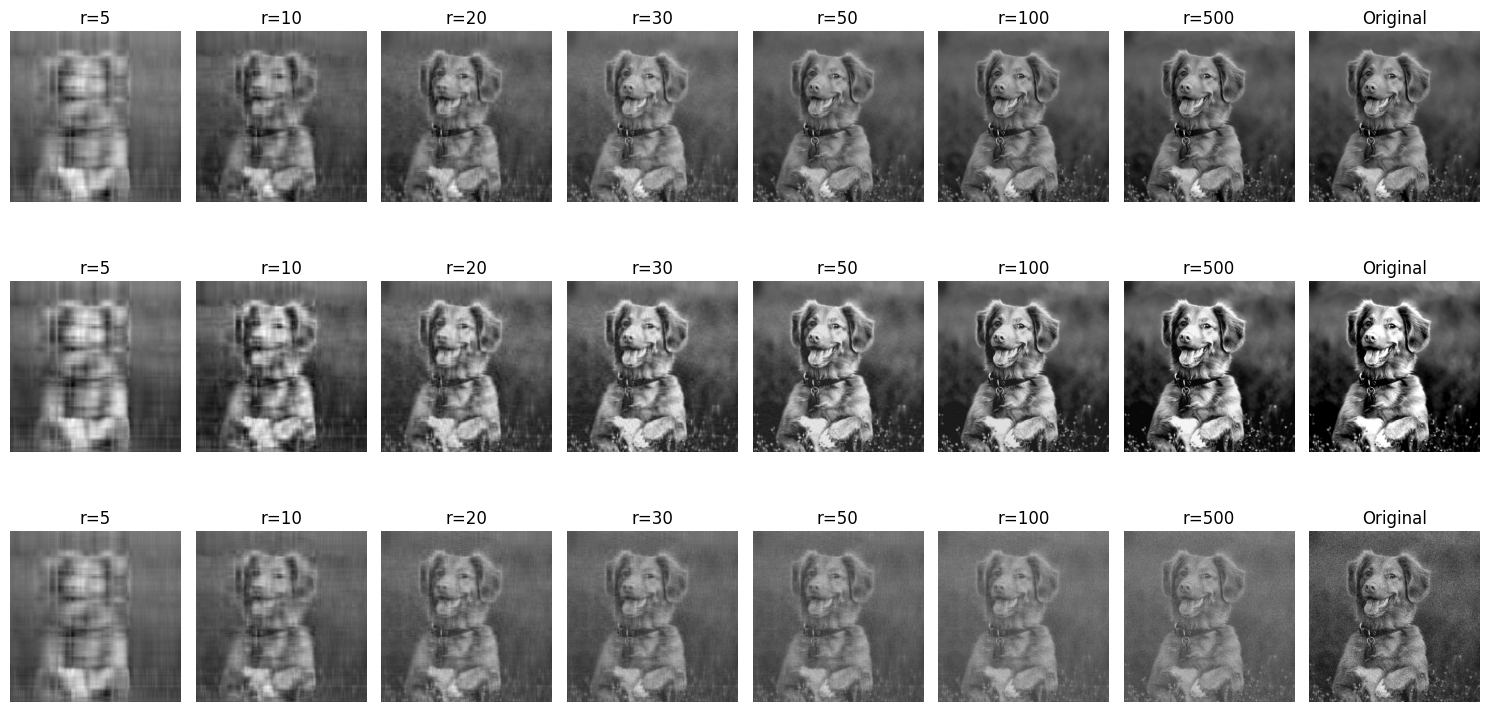

In [27]:
# Aplicar SVD para diferentes valores de "r" (três casos)
img = Image.fromarray(imageio.imread(
    "https://storage.googleapis.com/kaggle-datasets-images/2742826/4739736/2850b9592e450d523815d509b9500140/dataset-card.jpg"
)).convert("L")

contrast_img = ImageEnhance.Contrast(img).enhance(2) # Versão com maior contraste

noise_img = Image.fromarray(np.clip(np.array(img, dtype=np.float32) +
                                    np.random.normal(0, 65, np.array(img).shape),0, 255).astype(np.uint8)) # Versão com ruído

images = [img, contrast_img, noise_img]
titles = ["Original", "Contraste", "Ruído"]

ranks = [5, 10, 20, 30, 50, 100, 500]

plt.figure(figsize=(15, 8))

for row, (im, title) in enumerate(zip(images, titles)):

    X = np.array(im, dtype=np.float32)
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    S_diag = np.diag(S)

    for col, r in enumerate(ranks + ["orig"]):
        plt_idx = row * (len(ranks)+1) + col + 1
        plt.subplot(len(images), len(ranks)+1, plt_idx)

        # Ignorar a imagem original
        if r == "orig":
            plt.imshow(X, cmap='gray')
            plt.title("Original")

        # Aplicar SVD para os outros casos, variando r
        else:
            Xapprox = U[:, :r] @ S_diag[:r, :r] @ VT[:r, :]
            plt.imshow(Xapprox, cmap='gray')
            plt.title(f"r={r}")

        plt.axis('off')

plt.tight_layout()
plt.show()

A figura acima mostra o resultado de reconstrução para três diferentes variações, sendo essas: original (**primeira linha**), maior contraste (**segunda linha**) e ruído artificial (**terceira linha**). <br>
Observa-se que, ao aumentar o posto, o nível de reconstrução varia conforme a variante da imagem. No caso sem alterações, valores de *r* = 50 já produzem uma reconstrução bastante próxima da original. Para a versão com contraste aumentado, apenas a reconstrução com *r* = 500 se aproxima da imagem original. Por fim, na versão com ruído, nem mesmo *r* = 500 garante uma aproximação próxima da original, indicando que a maior complexidade da imagem dificulta o processo de reconstrução.



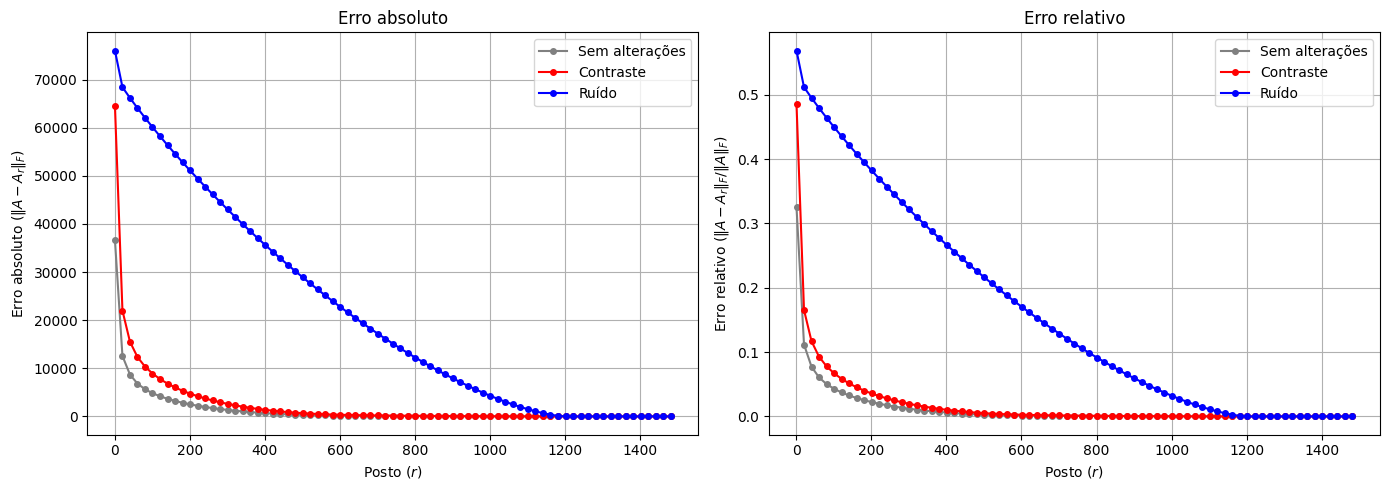

In [28]:
# Norma Frobenius
ranks = range(1, 1501, 20)

labels = ["Sem alterações", "Contraste", "Ruído"]
colors = ["gray", "red", "blue"]

errors_abs_all = []
errors_rel_all = []

for im in images:
    X = np.array(im, dtype=np.float32)
    U, S, VT = np.linalg.svd(X, full_matrices=False)
    S_diag = np.diag(S)

    errors_abs = []
    errors_rel = []
    norm_X = np.linalg.norm(X, 'fro')

    for r in ranks:
        Xapprox = U[:, :r] @ S_diag[:r, :r] @ VT[:r, :]
        err_abs = np.linalg.norm(X - Xapprox, 'fro')
        err_rel = err_abs / norm_X
        errors_abs.append(err_abs)
        errors_rel.append(err_rel)

    errors_abs_all.append(errors_abs)
    errors_rel_all.append(errors_rel)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, label in enumerate(labels):
    axes[0].plot(ranks, errors_abs_all[i], color=colors[i], label=label, marker='o', markersize=4, linestyle='-')
    axes[1].plot(ranks, errors_rel_all[i], color=colors[i], label=label, marker='o', markersize=4, linestyle='-')

# Erro absoluto
axes[0].set_xlabel("Posto ($r$)")
axes[0].set_ylabel(r"Erro absoluto ($\|A - A_r\|_F$)")
axes[0].set_title("Erro absoluto")
axes[0].grid(True)
axes[0].legend()

# Erro relativo
axes[1].set_xlabel("Posto ($r$)")
axes[1].set_ylabel(r"Erro relativo ($\|A - A_r\|_F / \|A\|_F$)")
axes[1].set_title("Erro relativo")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

A figura acima mostra o erro acumulado de reconstrução para cada caso em termos absolutos e relativos. <br>
Para a imagem sem perturbações (**linha cinza**), o comportamento segue o descrito anteriormente: *r* = 100 já proporciona uma reconstrução excelente, com perda de energia de apenas 4%. Na versão com contraste aumentado (**linha vermelha**), o padrão é similar, embora a perda seja ligeiramente maior para *r* = 100, cerca de 6%. Por fim, a imagem com ruído artificial (**linha azul**) é a mais difícil de reconstruir: somente com *r* = 800 a perda cai para aproximadamente 10%, e apenas com *r* = 1000 o erro de reconstrução se aproxima dos 5% observados nos outros casos.

## **4. Conclusões**

Em resumo, a qualidade da reconstrução via SVD depende da complexidade da imagem: imagens sem alterações ou com contraste moderado são bem reconstruídas com postos relativamente baixos, enquanto imagens com ruído exigem postos muito maiores para atingir erro semelhante. <br>
De qualquer forma, é importante ressaltar que a imagem usada veio em formato JPEG, ou seja, já possui um certo nível de reconstrução. Os resultados para imagens em formato *lossless* podem ser diferentes dos aqui mostrados.